In [1]:
%matplotlib inline
from galaxy_analysis.plot.plot_styles import *

import matplotlib.pyplot as plt
import numpy as np
import onezone.data_tables as DT
from galaxy_analysis.utilities import convert_abundances as convert
import onezone.imf as imf
import h5py

In [2]:
CCSN = DT.StellarYieldsTable('SNII')
wind = DT.StellarYieldsTable('wind')
fsize = 17
rc('text',usetex=False)
rc('font',size=fsize)






In [3]:
CCSN.x['mass'].size

12

In [4]:
def make_manual_table(table, group, filename, datadir = './'):
    #
    # Load from the h5 file
    #
    hf = h5py.File(datadir + filename, 'r')
    
    grp = hf[group]
    
    
    table.yield_type = group
    table.data_dir   = datadir
    
    table.x['mass']        = np.unique( grp['M'][()] )
    table.x['metallicity'] = np.unique( grp['Z'][()] )
    
    table.nbins['mass'] = np.size(table.x['mass'])
    table.nbins['metallicity'] = np.size(table.x['metallicity'])
    
    table._array_size =  int( np.prod( list(table.nbins.values())))
    
    for i,be in enumerate(grp['yield_names']):
        e = be.decode('utf-8')
            
        table.y[e] = grp['yields'][:,:,i]
        
    table._available_yields = table.y.keys()
    
    hf.close()
    return
    
    

In [16]:
ddir = "/home/aemerick/code/galaxy_analysis/individualstar_data/construct_tables/"

#
# load LC18 yields
#
LC18 = {}
for ytype in ['SN','Wind']:
    LC18[ytype] = {}
    
    for vr in ['R_0','R_150','R_300','mixture']:
        fname = 'LC18_' + vr + '-' + 'LC18_winds_' + vr + '-FRUITY-PopIII.h5'
        
        LC18[ytype][vr] = DT.StellarYieldsTable(ytype,fname,manual_table=True,data_dir=ddir)
        make_manual_table(LC18[ytype][vr], ytype, fname, datadir = ddir)
        


In [17]:
def interpolate_many(vals_list, fields, table):
    return np.array([table.interpolate( [x,y], fields)[0] for x,y in vals_list])

def get_abundance_ratio(vals_list, element1, element2, yield_type):
    
    #mass1 = interpolate_many(vals_list, element1, table)
    #mass2 = interpolate_many(vals_list, element2, table)
    
    aratios = np.array( [convert.get_yield_ratio(element1,element2,x,y,yield_type) for x,y in vals_list]  )
    return aratios

In [18]:
#
#
# LC18
#
#
def make_grid_points(table):
    x,y = np.meshgrid(table.x['mass'], table.x['metallicity'])

    points = [(0,0)]*np.size(table.x['mass'])*np.size(table.x['metallicity'])
    i = 0
    for yi in table.x['metallicity']:
        for xi in table.x['mass']:
            points[i] = (xi,yi)
            i = i + 1

    #z = get_abundance_ratio( points, 'O', 'Fe', 'SNII')


    return x, y, points

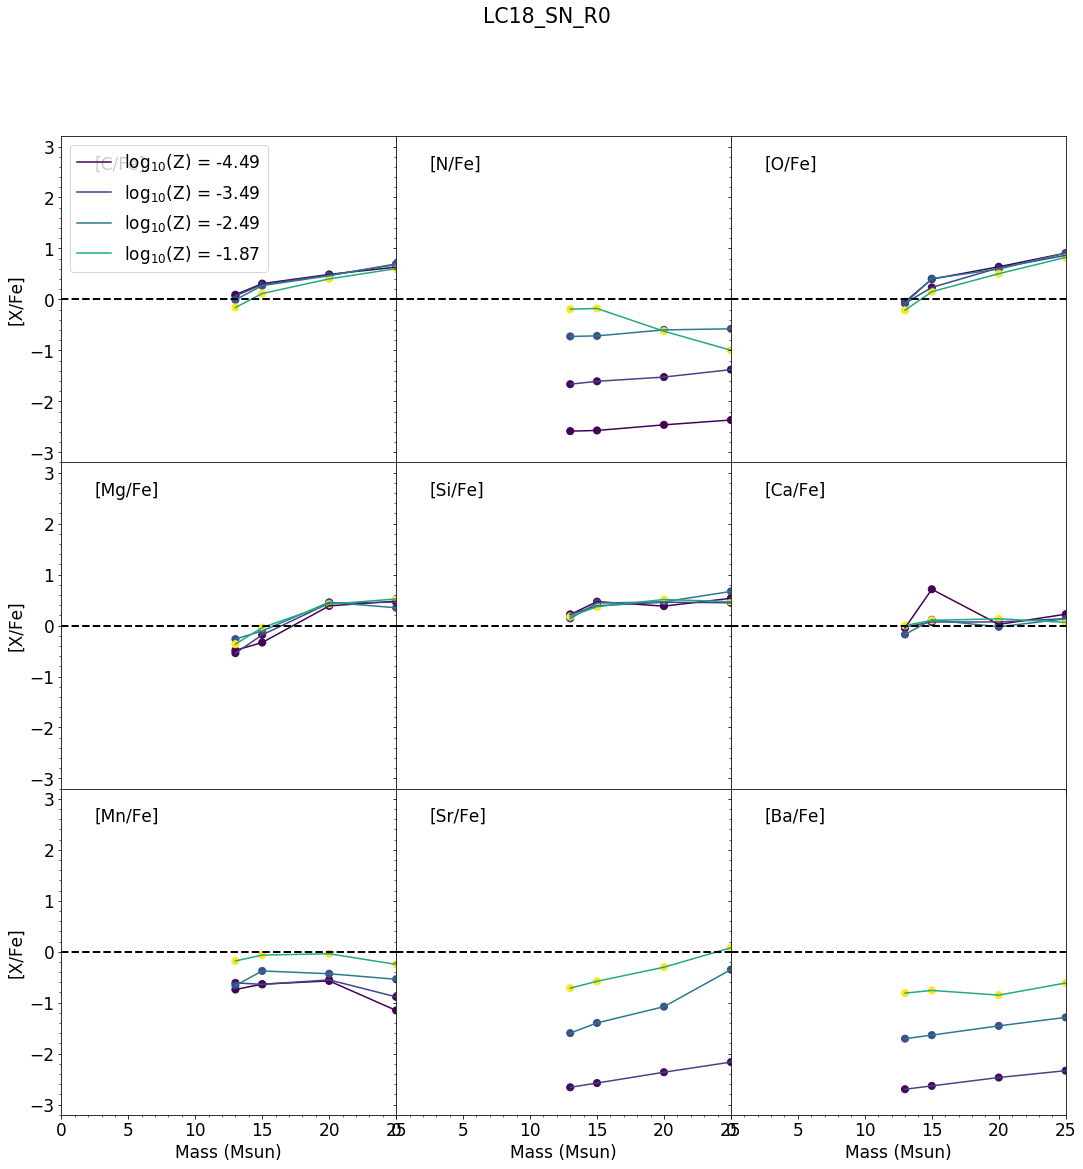

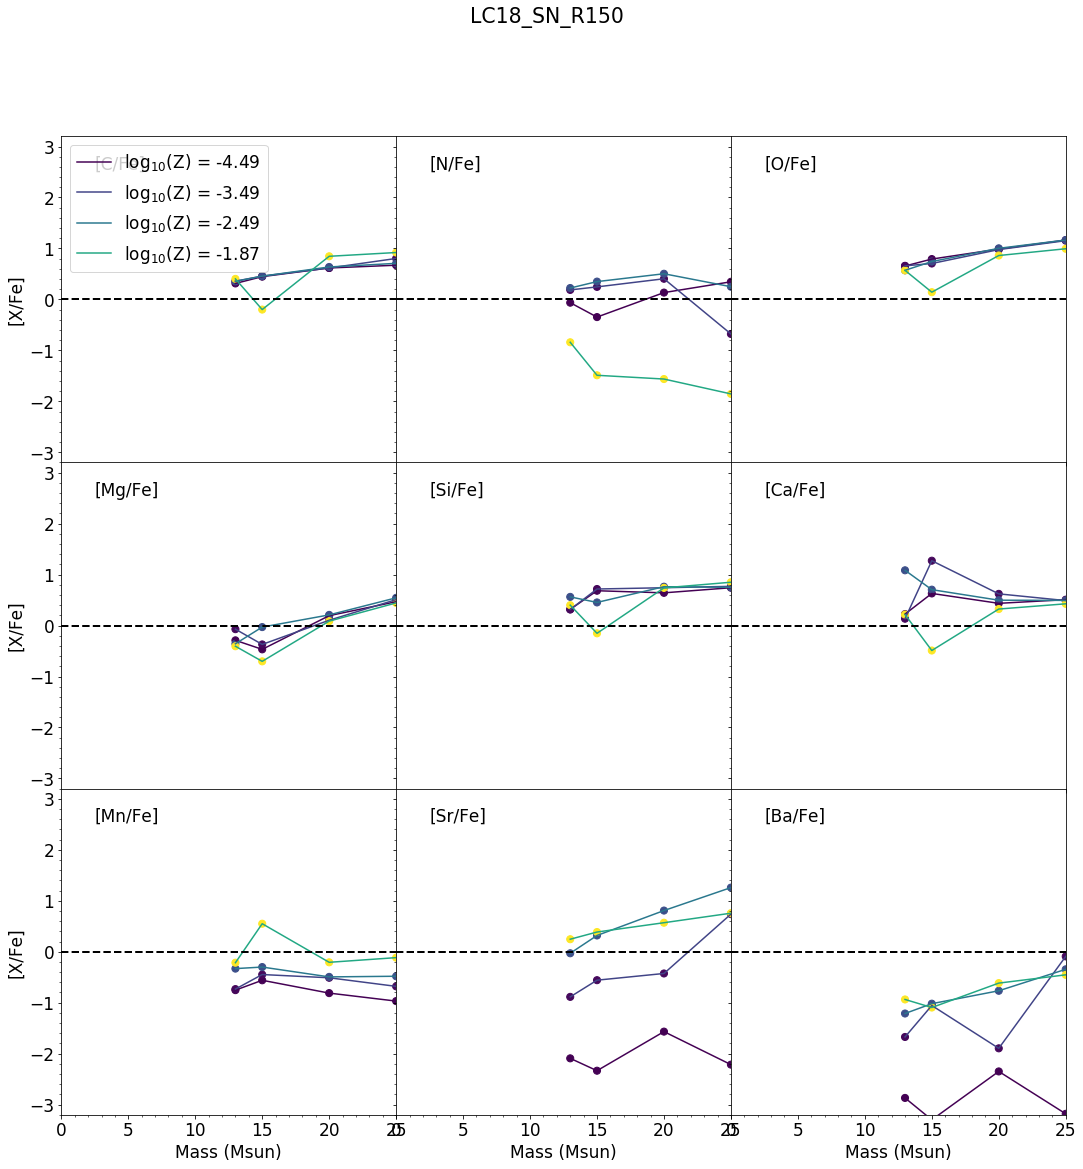

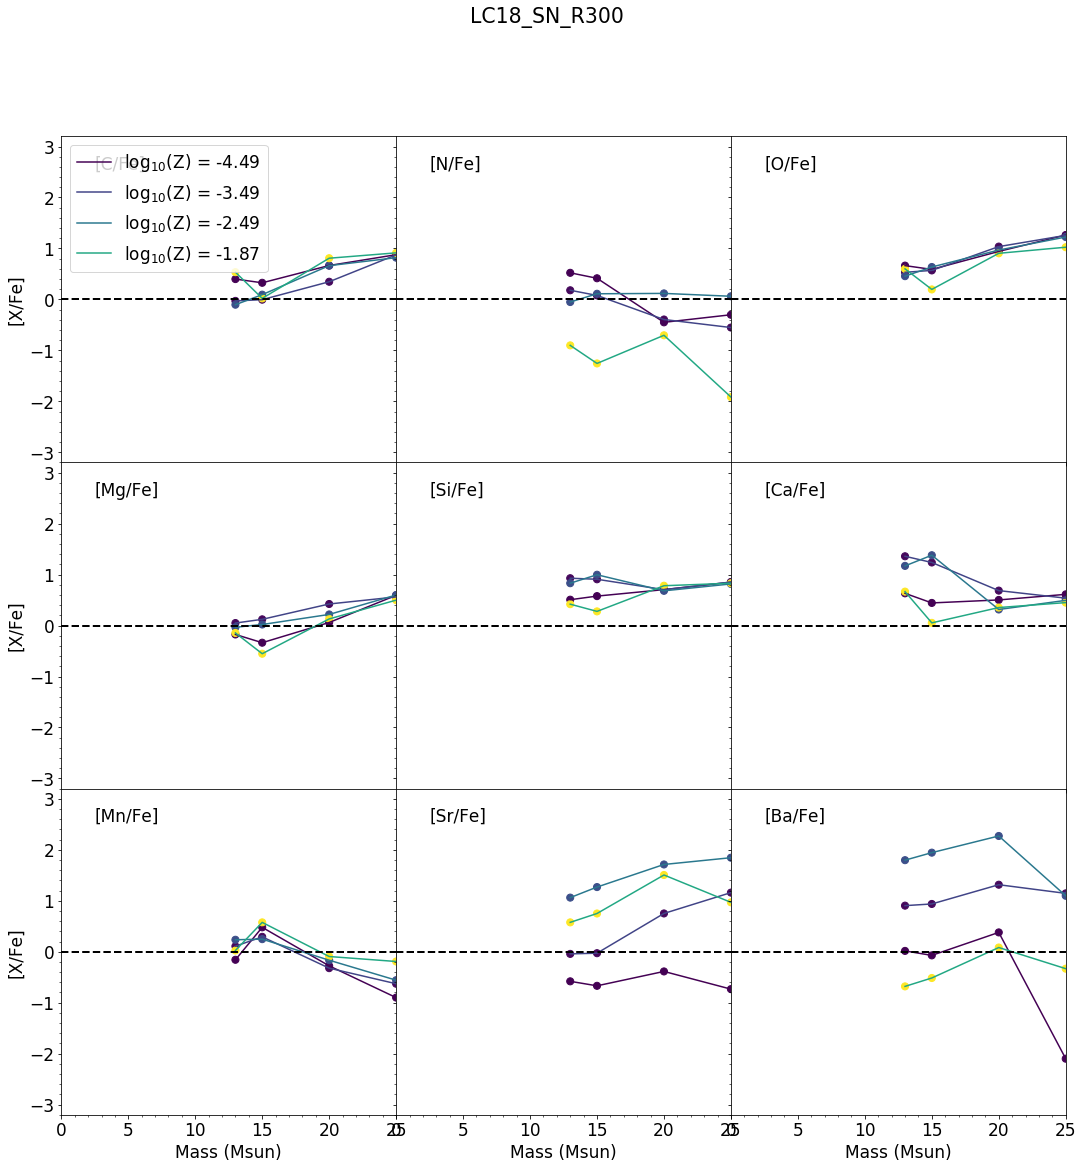

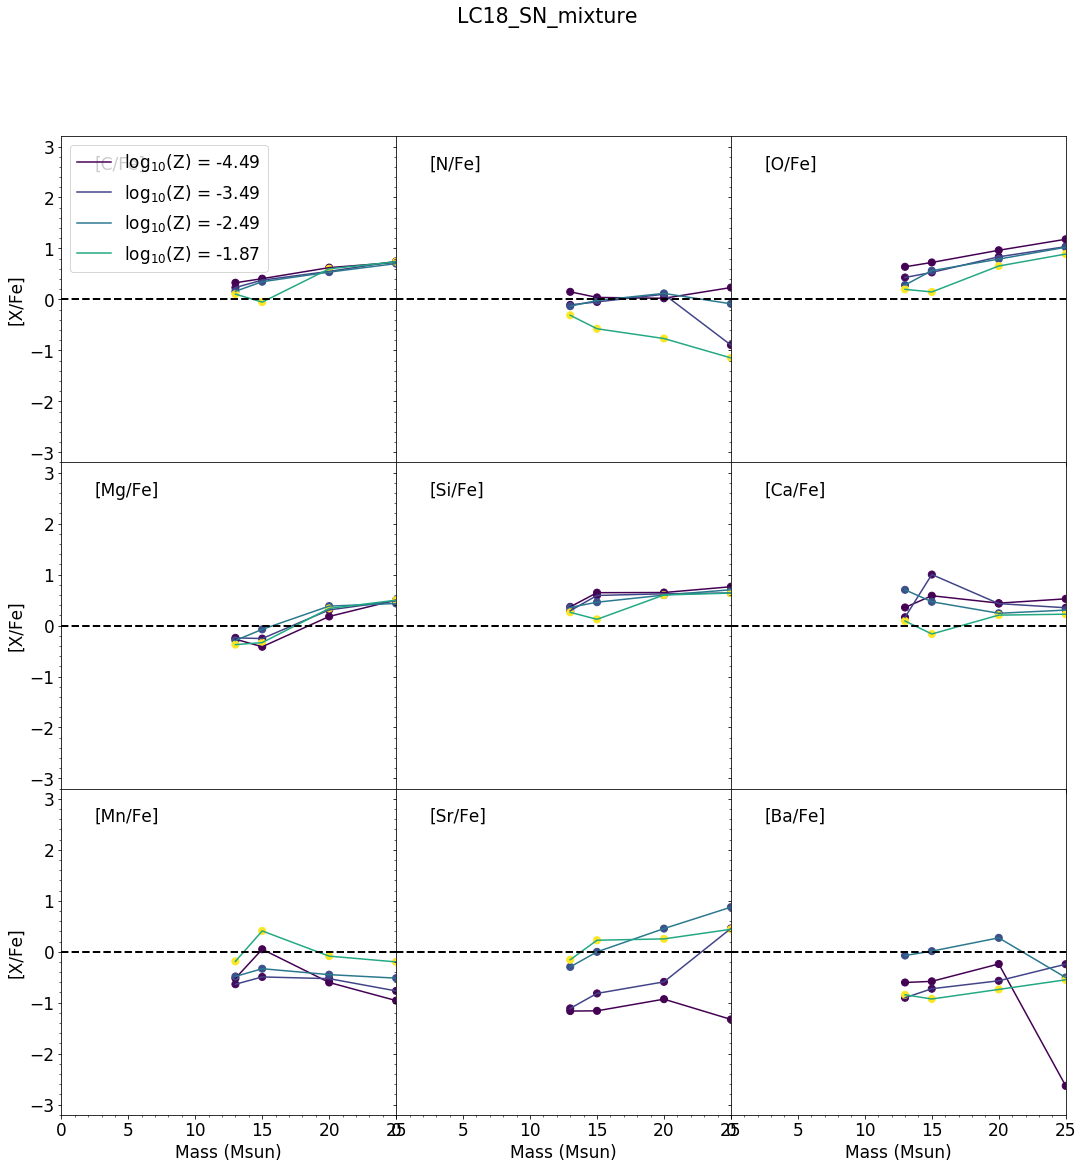

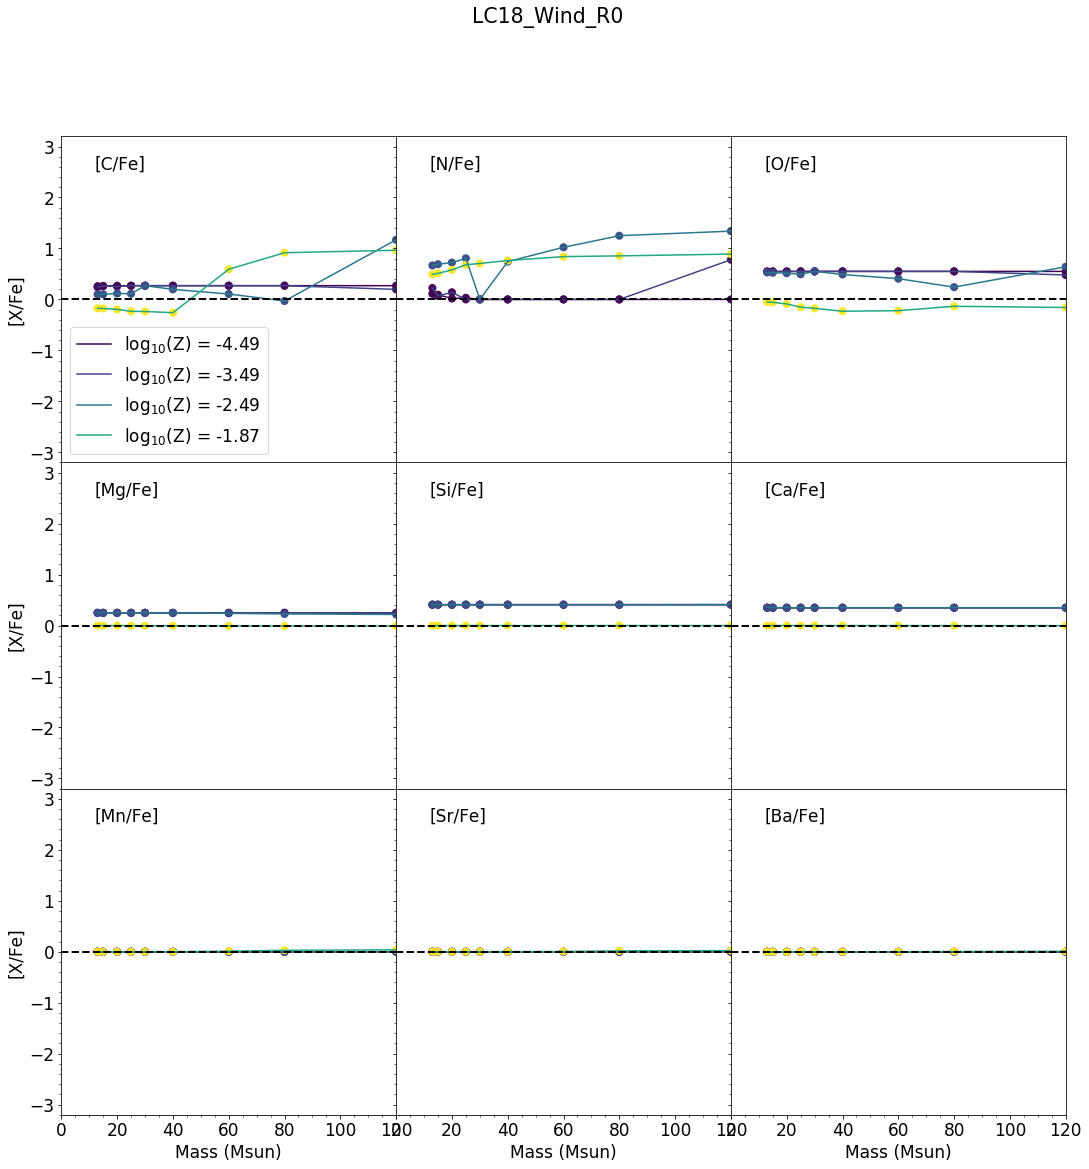

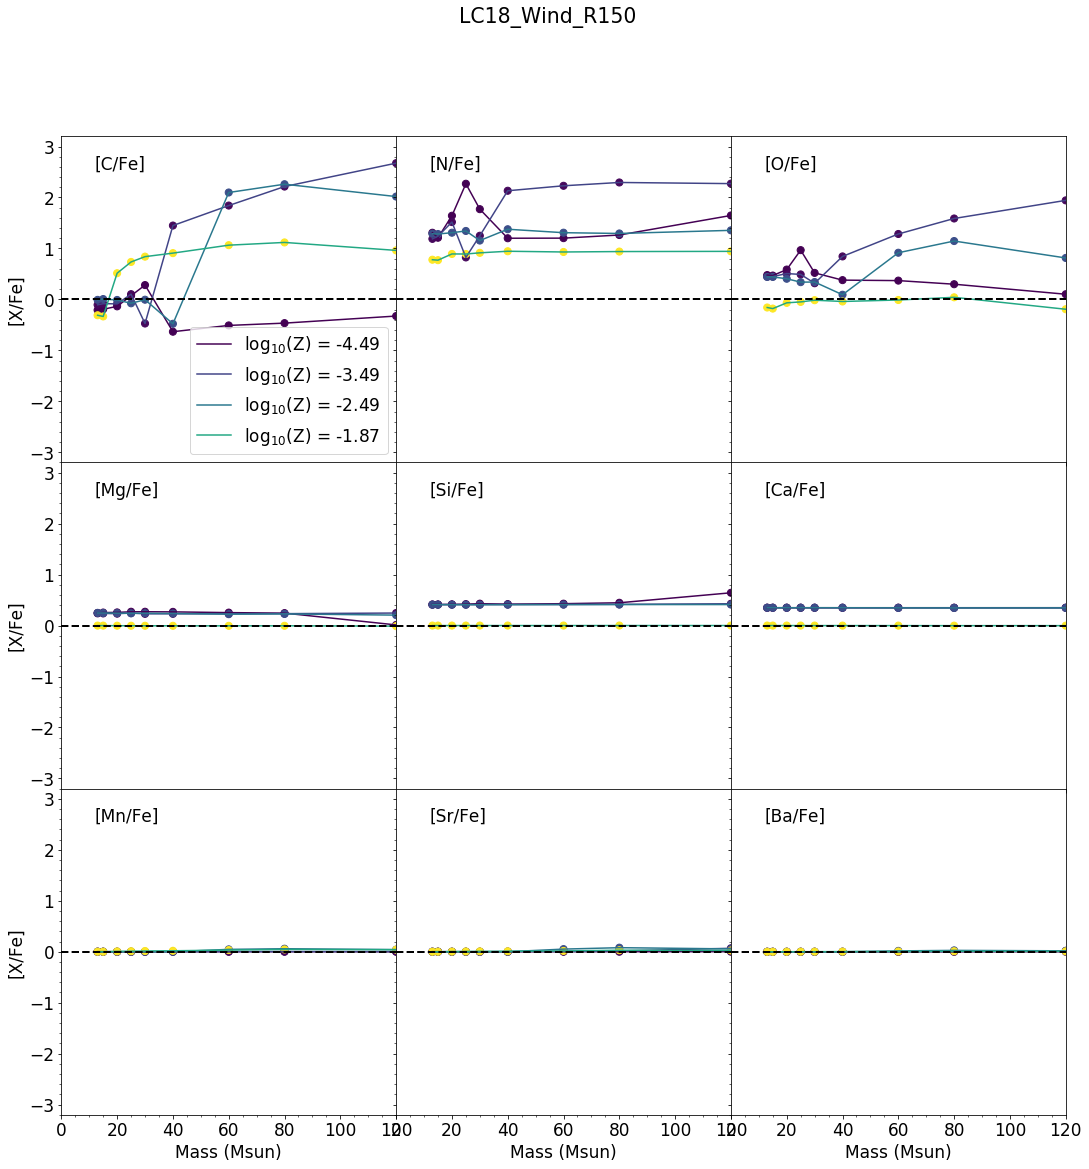

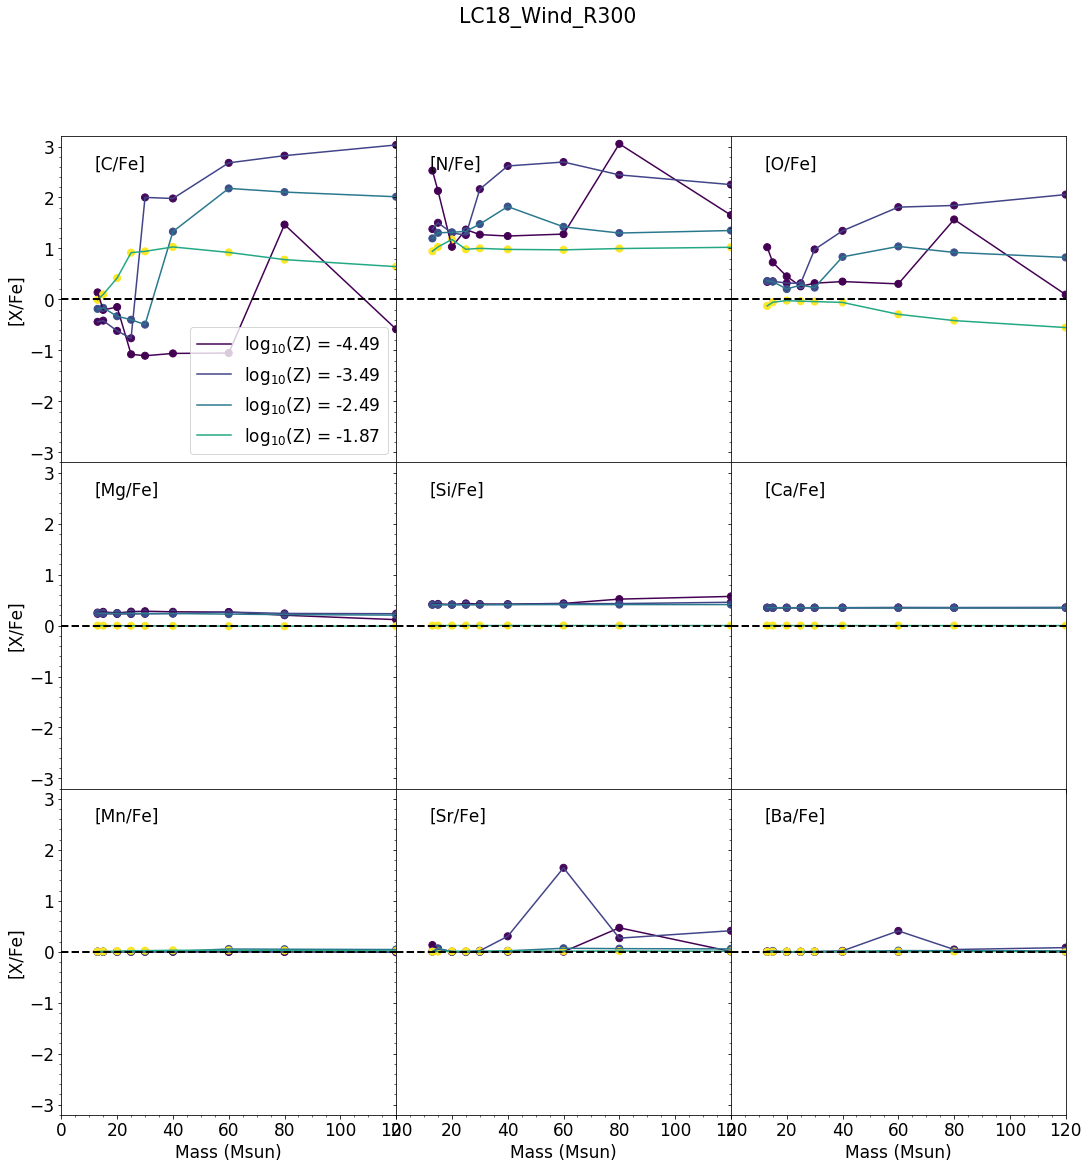

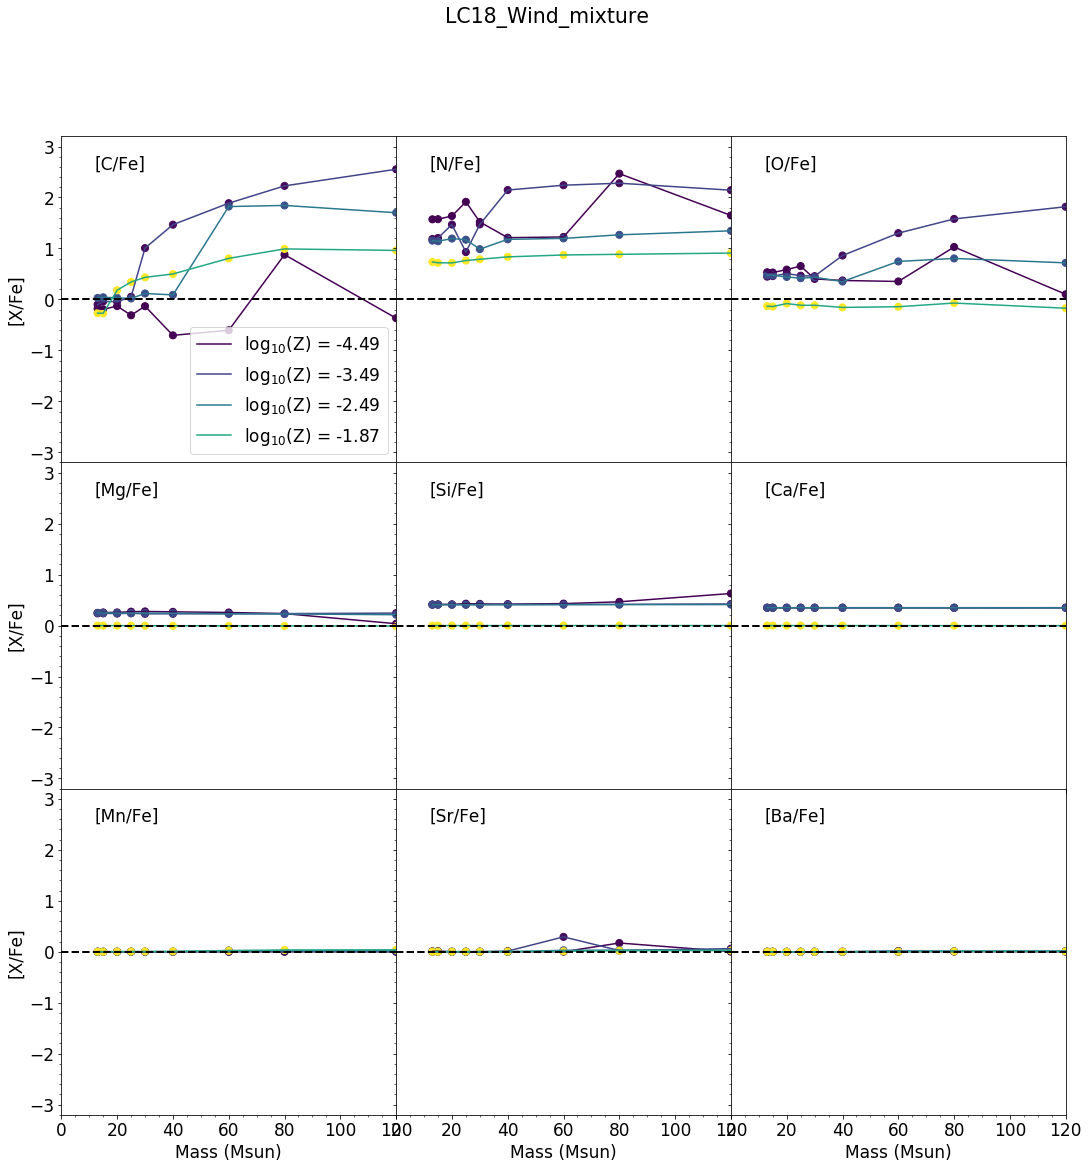

In [47]:
def plot_ratios_vs_mass(table, outname=None,title=False):
    
    numerators    = ['C','N','O','Mg','Si','Ca','Mn','Sr','Ba']
    denominators  = ['Fe']

    ncol = 3
    nrow = 3

    fig,ax = plt.subplots(nrow, ncol, sharex=True,sharey=True)
    fig.set_size_inches(ncol*6,nrow*6)

    fig.subplots_adjust(hspace = 0, wspace = 0)

    axi = 0
    axj = 0
    
    if 'SN' in outname:
        xlim = (0,25)
    if "Wind" in outname:
        xlim = (0,120)

    x,y,points = make_grid_points(table)
    
    bins = np.arange(-30,0, 0.1)
    for denom_element in denominators:

        for num_element in numerators:
            index = (axi,axj)



            if num_element == denom_element:
                axj = axj + 1
                continue

            #z = get_abundance_ratio( points, num_element, denom_element, table.yield_type)
            z = table.interpolate_yield_ratio(num_element, denom_element, points)

            newshape = (table.x['metallicity'].size, table.x['mass'].size)
            
            ax[index].scatter(x, z.reshape(newshape), c = y, s = 50)#, alpha = 0.5)

            for i in np.arange(table.x['metallicity'].size):
                ax[index].plot(x[i],z.reshape(newshape)[i], color = viridis(i/(5*1.0)), 
                              label = "log$_{10}$(Z) = %0.2f"%(np.log10(y.reshape(newshape)[i][0])))

            ax[index].set_xlim(xlim)
            ax[index].plot(xlim,[0,0],lw=2,color='black',ls='--')
            ax[index].set_ylim(-3.2,3.2)

            #ax[index].set_ylabel()
            
            if axj == 0:
                ax[index].set_ylabel("[X/" + denom_element + "]")
            
            xy = (0.1,0.9)
            
            ax[index].annotate("["+num_element + "/" + denom_element +"]",
                               xy,xy, xycoords = 'axes fraction')
            axj = axj + 1
            if axj >= ncol:
                axj = 0
                axi = axi + 1        

    plt.minorticks_on()
    ax[(0,0)].legend(loc='best')
    for i in np.arange(ncol):
        ax[(nrow-1,i)].set_xlabel('Mass (Msun)')


    if title:
        fig.suptitle(outname.split('.p')[0])

        
    if not (outname is None):
        fig.savefig(outname,bbox_inches="tight")
        
    return 

for t in ['SN','Wind']:
    plot_ratios_vs_mass(LC18[t]['R_0'], outname = 'LC18_'+t+'_R0.png', title=True)
    plot_ratios_vs_mass(LC18[t]['R_150'], outname = 'LC18_'+t+'_R150.png',title=True)
    plot_ratios_vs_mass(LC18[t]['R_300'], outname = 'LC18_'+t+'_R300.png',title=True)
    plot_ratios_vs_mass(LC18[t]['mixture'], outname = 'LC18_'+t+'_mixture.png',title=True)


    #plot_ratios_vs_mass(LC18['SN']['R_300'], outname = 'LC18_SN_R300.png')


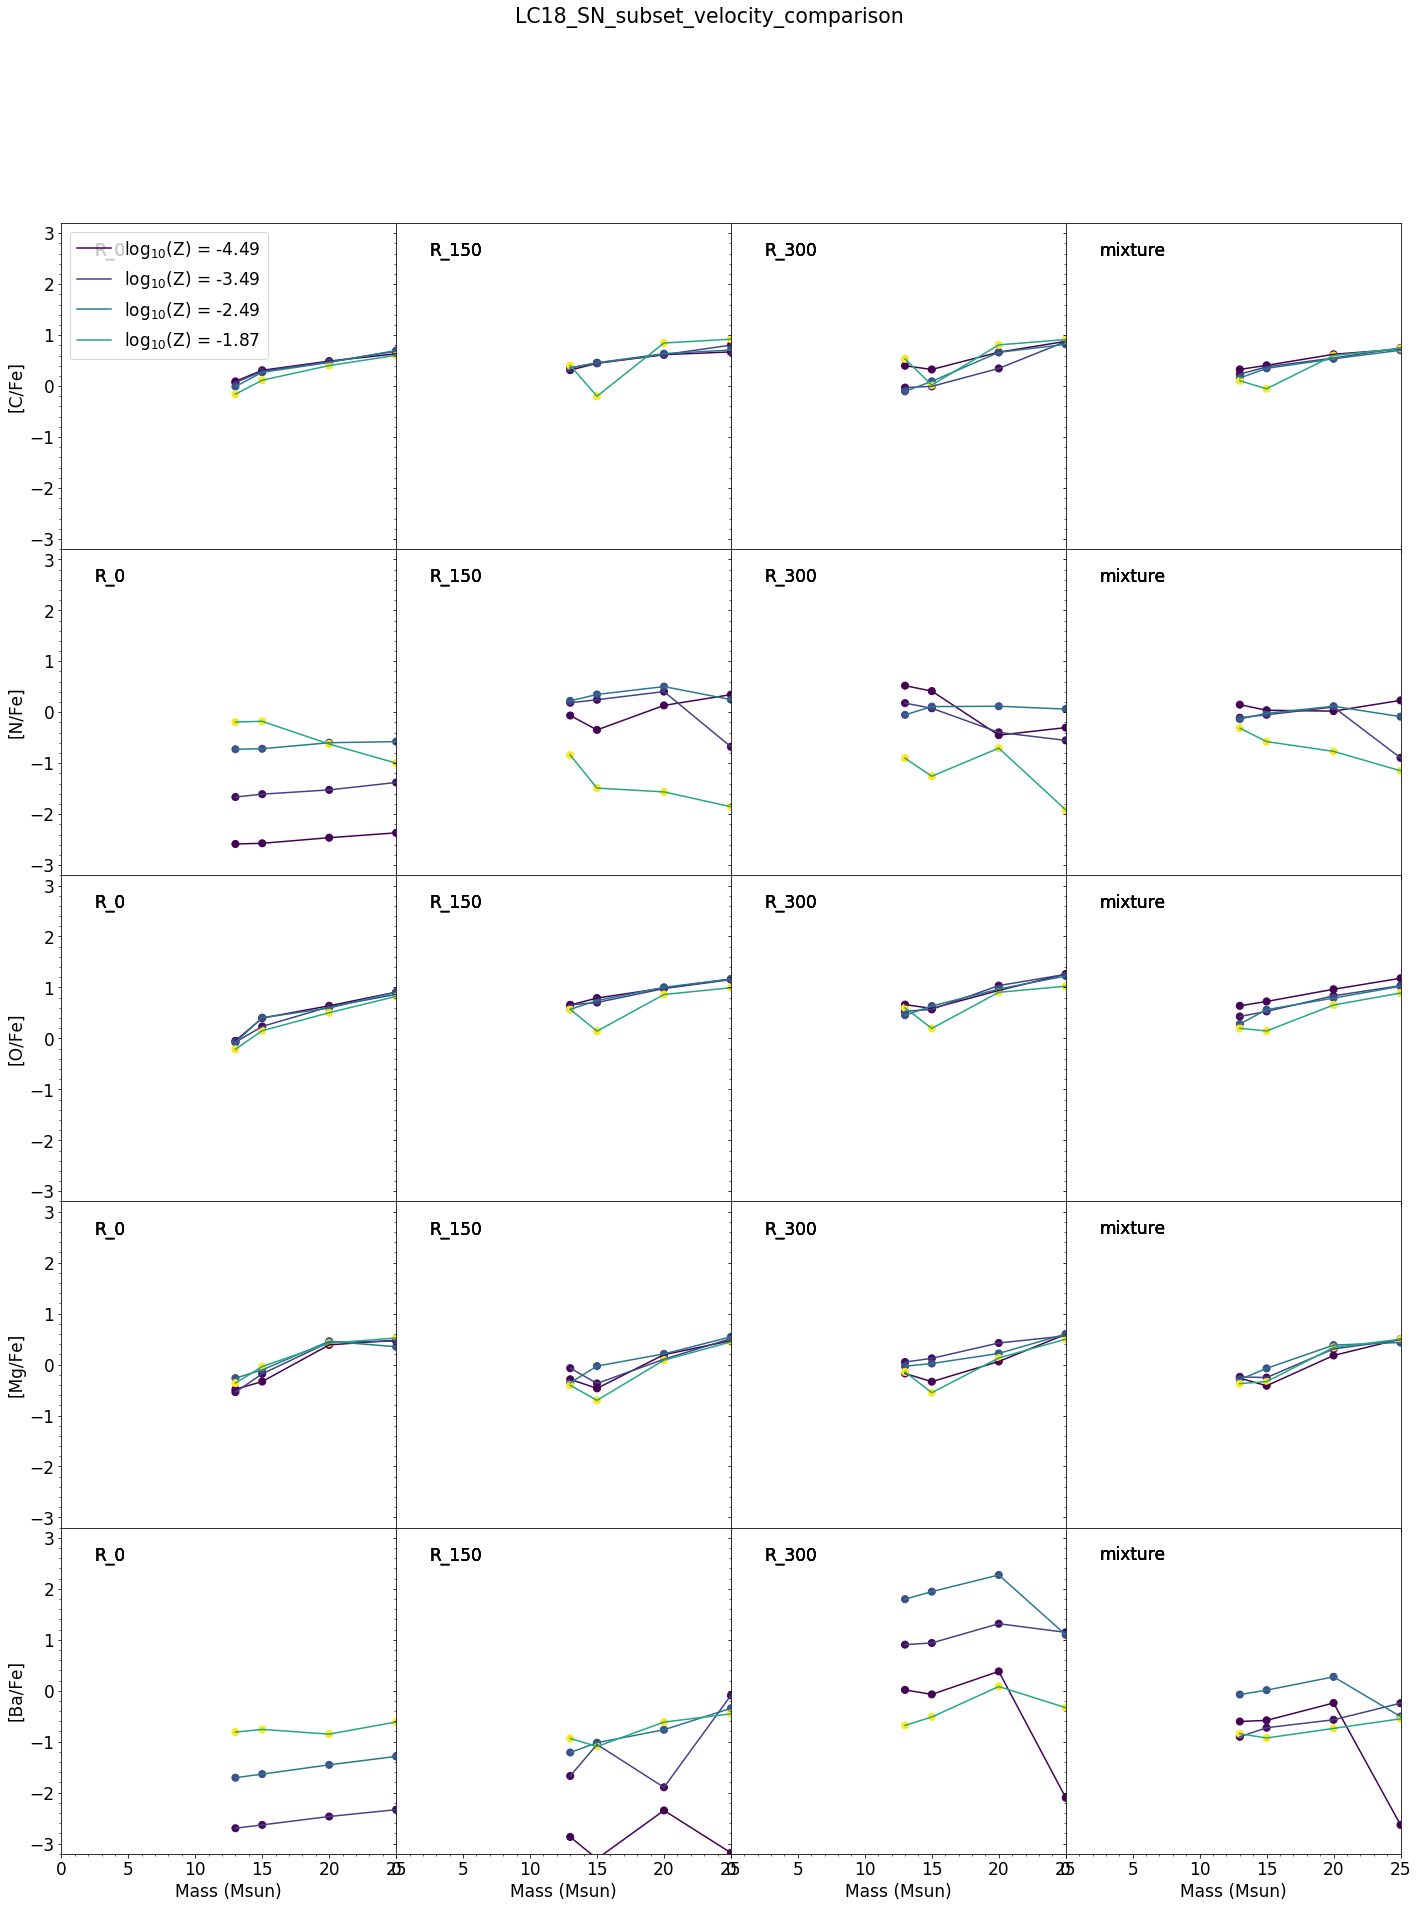

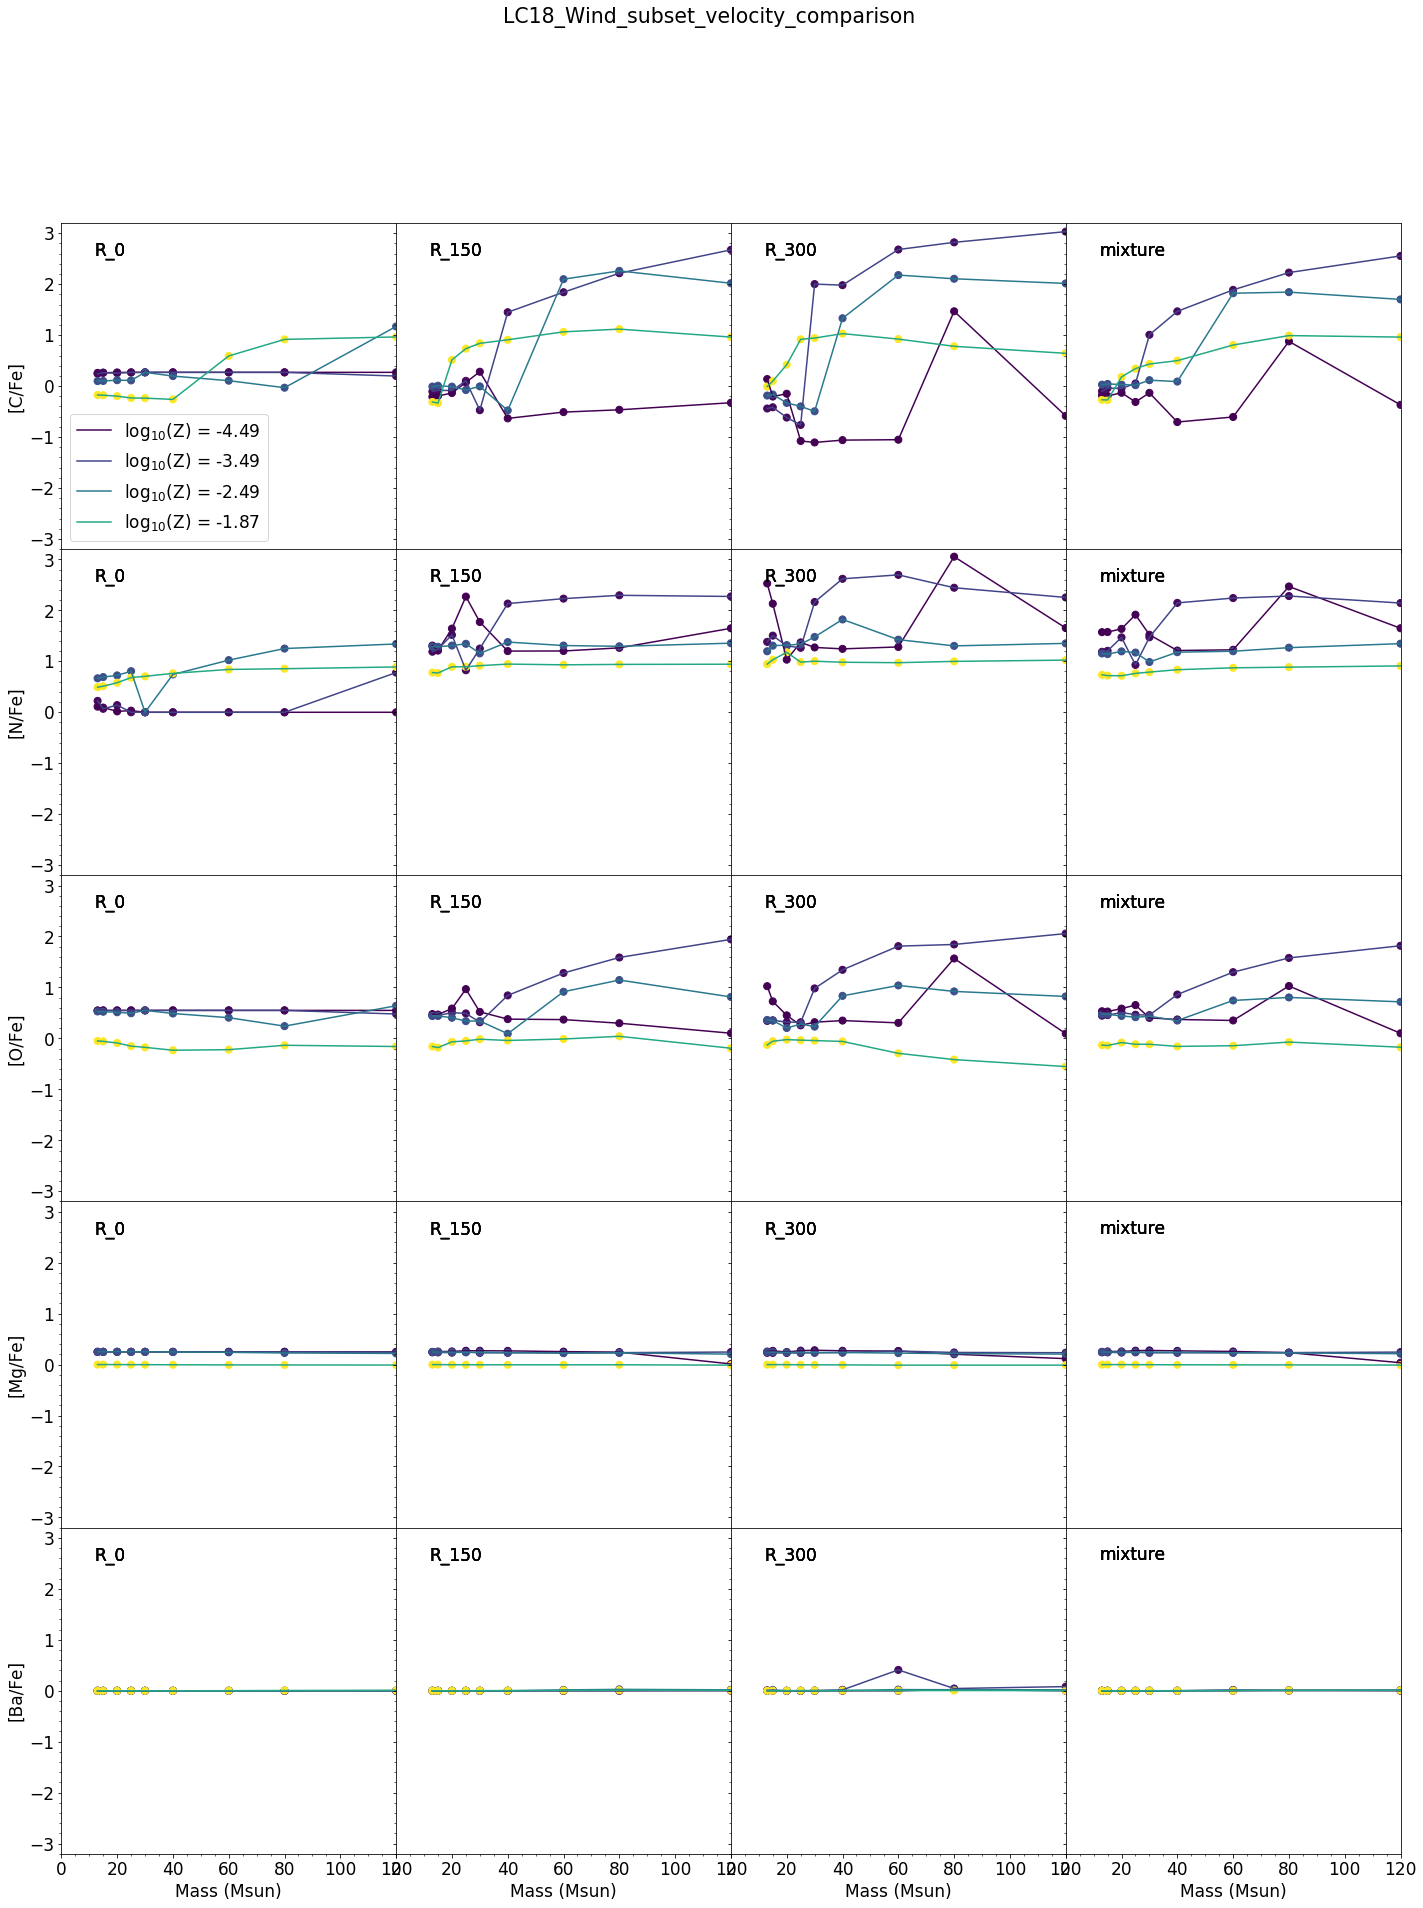

In [46]:
def plot_velocity_comparison(outname=None,title=False, ytype='SN'):
    
    numerators    = ['C','N','O','Mg','Ba']
    denom_element = 'Fe'

    ncol = 4
    nrow = len(numerators)

    fig,ax = plt.subplots(nrow, ncol, sharex=True,sharey=True)
    fig.set_size_inches(ncol*6,nrow*6)

    fig.subplots_adjust(hspace = 0, wspace = 0)

    axi = 0
    axj = 0

    if ytype == 'SN':
        xlim = (0,25)
    elif ytype == "Wind":
        xlim = (0,120)

    
    bins = np.arange(-30,0, 0.1)
    for num_element in numerators:

        if num_element == denom_element:
            axj = axj + 1
            continue

        #z = get_abundance_ratio( points, num_element, denom_element, table.yield_type)
        for tname in LC18[ytype].keys():
            index = (axi,axj)
            
            x,y,points = make_grid_points(LC18[ytype][tname])
            
            z = LC18[ytype][tname].interpolate_yield_ratio(num_element, denom_element, points)

            newshape = (LC18[ytype][tname].x['metallicity'].size, LC18[ytype][tname].x['mass'].size)
            
            ax[index].scatter(x, z.reshape(newshape), c = y, s = 50)#, alpha = 0.5)

            for i in np.arange(LC18[ytype][tname].x['metallicity'].size):
                ax[index].plot(x[i],z.reshape(newshape)[i], color = viridis(i/(5*1.0)), 
                                  label = "log$_{10}$(Z) = %0.2f"%(np.log10(y.reshape(newshape)[i][0])))
 
 
                ax[index].set_xlim(xlim)
                ax[index].set_ylim(-3.2,3.2)

                #ax[index].set_ylabel()
            
                if axj == 0:
                    ax[index].set_ylabel("["+num_element + "/" + denom_element +"]")
            
                xy = (0.1,0.9)
            
                ax[index].annotate(tname,
                               xy,xy, xycoords = 'axes fraction')
            axj = axj + 1
            if axj >= ncol:
                axj = 0
                axi = axi + 1        

    plt.minorticks_on()
    ax[(0,0)].legend(loc='best')
    for i in np.arange(ncol):
        ax[(nrow-1,i)].set_xlabel('Mass (Msun)')


    if title:
        fig.suptitle(outname.split('.p')[0])

        
    if not (outname is None):
        fig.savefig(outname,bbox_inches="tight")
        
    return 

plot_velocity_comparison(outname = 'LC18_SN_subset_velocity_comparison.png',title=True,ytype='SN')
plot_velocity_comparison(outname = 'LC18_Wind_subset_velocity_comparison.png',title=True,ytype='Wind')

    #plot_ratios_vs_mass(LC18['SN']['R_300'], outname = 'LC18_SN_R300.png')


In [35]:
x,y = np.meshgrid(CCSN.x['mass'], CCSN.x['metallicity'])

points = [(0,0)]*np.size(CCSN.x['mass'])*np.size(CCSN.x['metallicity'])
i = 0
for yi in CCSN.x['metallicity']:
    for xi in CCSN.x['mass']:
        points[i] = (xi,yi)
        i = i + 1

z = get_abundance_ratio( points, 'O', 'Fe', 'SNII')

TypeError: list indices must be integers or slices, not tuple

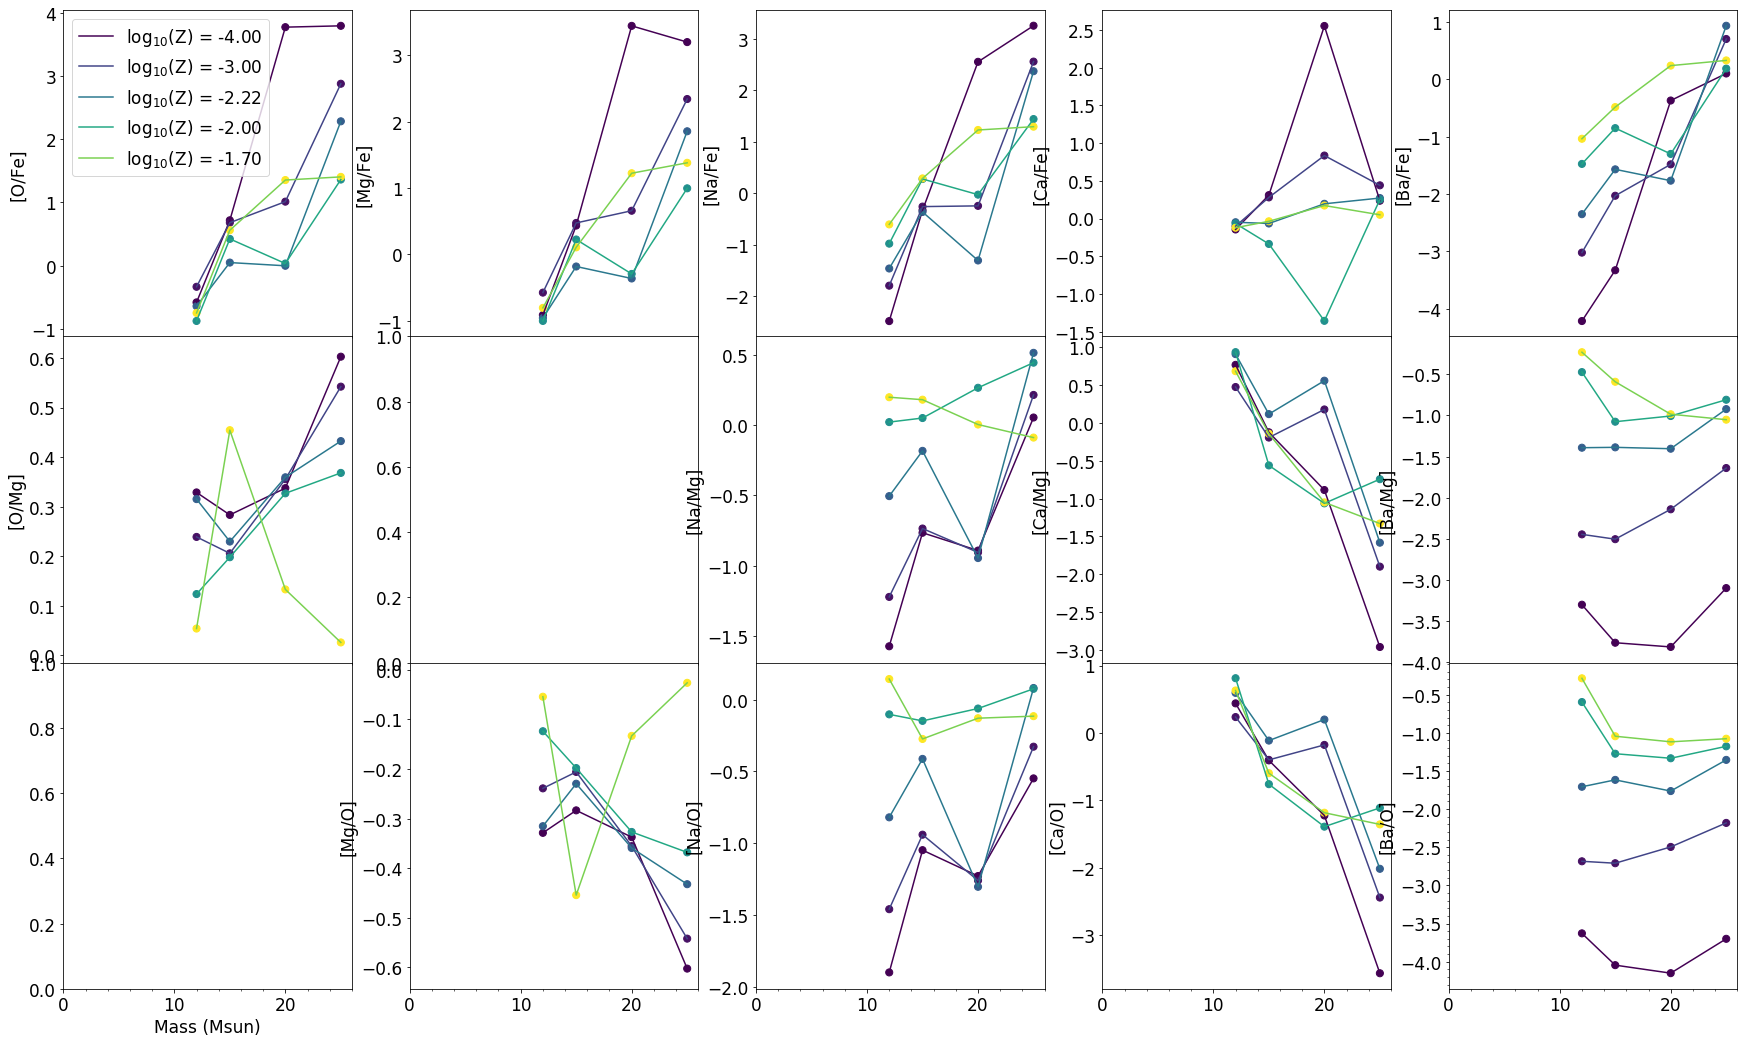

In [89]:

numerators    = ['O', 'Mg', 'Na', 'Ca','Ba']
denominators  = ['Fe','Mg','O']

ncol = len(numerators)
nrow = len(denominators)

fig,ax = plt.subplots(nrow, ncol, sharex=True)
fig.set_size_inches(ncol*6,nrow*6)

fig.subplots_adjust(hspace = 0)# wspace = 0)

axi = 0
axj = 0
    


bins = np.arange(-30,0, 0.1)
for denom_element in denominators:
    
    for num_element in numerators:
        index = (axi,axj)


        
        if num_element == denom_element:
            axj = axj + 1
            continue
        
        z = get_abundance_ratio( points, num_element, denom_element, 'SNII')

        ax[index].scatter(x, z.reshape(5,12), c = y, s = 50)#, alpha = 0.5)
        
        for i in np.arange(5):
            ax[index].plot(x[i],z.reshape(5,12)[i], color = viridis(i/(5*1.0)), 
                          label = "log$_{10}$(Z) = %0.2f"%(np.log10(y.reshape(5,12)[i][0])))
        
        ax[index].set_xlim(0,26)
        
        ax[index].set_ylabel("["+num_element + "/" + denom_element +"]")
        
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1        

plt.minorticks_on()
ax[(0,0)].legend(loc='best')
for i in np.arange(np.size(ncol)):
    ax[(nrow-1,i)].set_xlabel('Mass (Msun)')



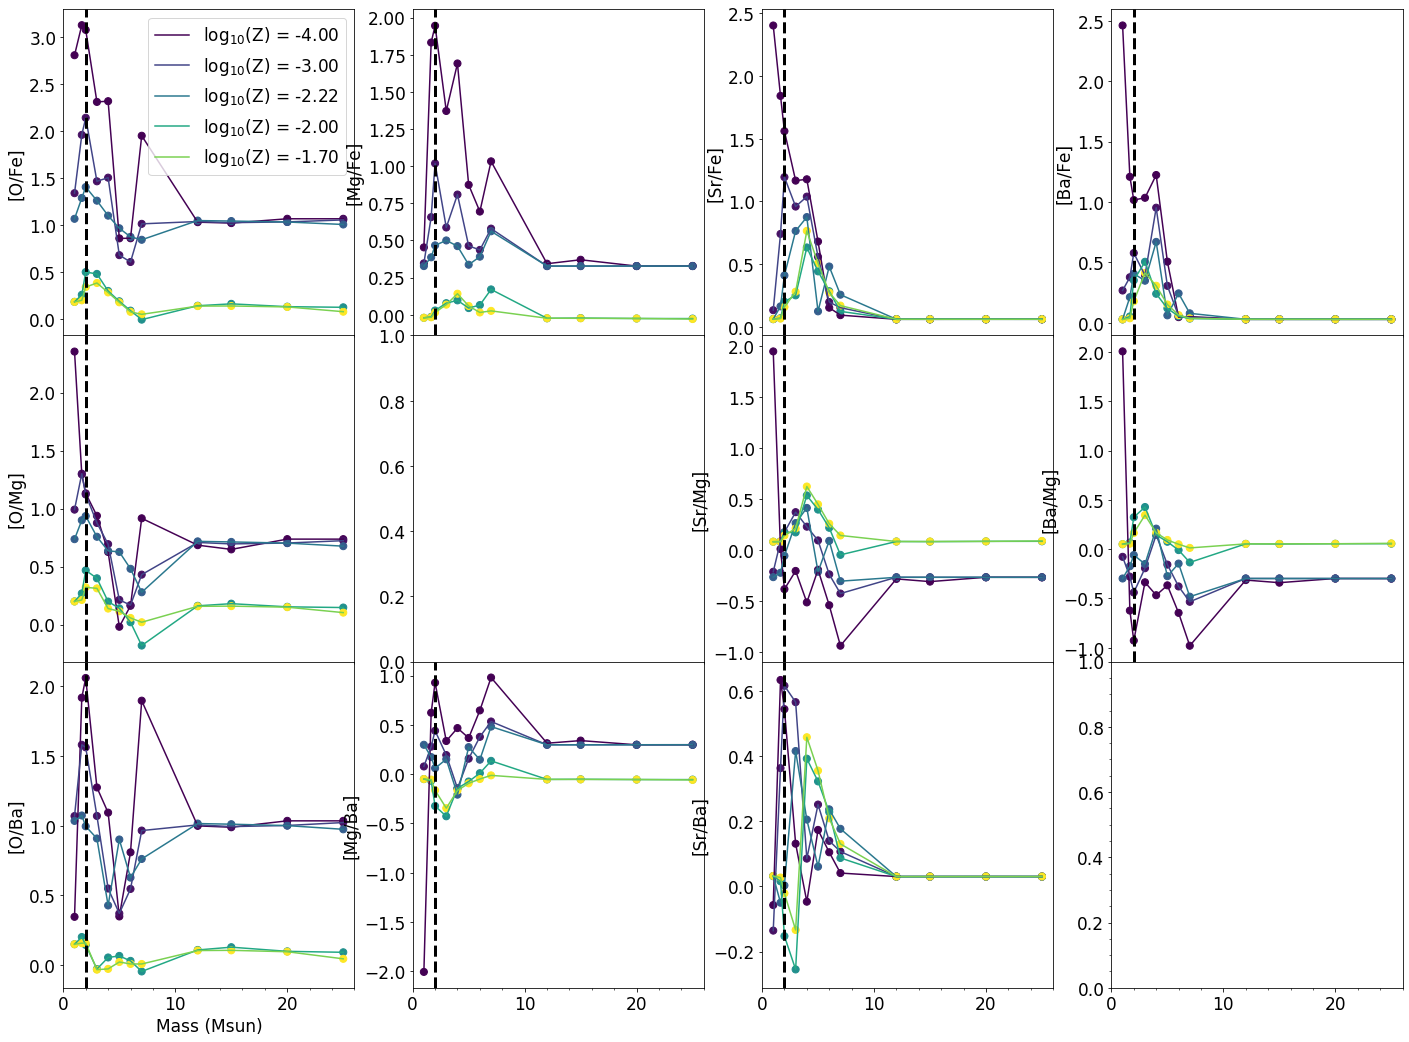

In [86]:

numerators    = ['O', 'Mg',  'Sr','Ba']
denominators  = ['Fe','Mg','Ba']

ncol = len(numerators)
nrow = len(denominators)

fig,ax = plt.subplots(nrow, ncol, sharex=True)
fig.set_size_inches(ncol*6,nrow*6)

fig.subplots_adjust(hspace = 0)# wspace = 0)

axi = 0
axj = 0
    


bins = np.arange(-30,0, 0.1)
for denom_element in denominators:
    
    for num_element in numerators:
        index = (axi,axj)


        
        if num_element == denom_element:
            axj = axj + 1
            continue
        
        z = get_abundance_ratio( points, num_element, denom_element, 'wind')

        ax[index].scatter(x, z.reshape(5,12), c = y, s = 50)#, alpha = 0.5)
        
        for i in np.arange(5):
            ax[index].plot(x[i],z.reshape(5,12)[i], color = viridis(i/(5*1.0)), 
                          label = "log$_{10}$(Z) = %0.2f"%(np.log10(y.reshape(5,12)[i][0])))
        
        ax[index].set_xlim(0,26)
        
        ax[index].set_ylabel("["+num_element + "/" + denom_element +"]")
        ylim = ax[index].get_ylim()
        ax[index].plot([2.0,2.0],ylim,color='black',lw=3,ls='--')
        ax[index].set_ylim(ylim)
        
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1        

plt.minorticks_on()
ax[(0,0)].legend(loc='best')
for i in np.arange(np.size(ncol)):
    ax[(nrow-1,i)].set_xlabel('Mass (Msun)')



In [ ]:
masses = CCSN.masses

points = zip(masses, 1.0E-4)


get_abundance_ratio(  [[10.0,0.001], [15.0,0.001]], 'O','Fe','SNII')

In [ ]:
mass_values = np.linspace(1.0,100.0,128.0)
z_values    = np.ones(128)*1.0E-4
#np.linspace(1.0E-4, 0.01,128.0)

mass_centers = 0.5*(mass_values[1:] +  mass_values[:-1])
z_centers    = 0.5*(z_values[1:] + z_values[:-1])

plot_mmesh, plot_zmesh = np.meshgrid(mass_values, z_values)

mmesh, zmesh = np.meshgrid(  mass_centers, z_centers)

mflat, zflat = mmesh.flatten(), zmesh.flatten()


vals = zip(mflat, zflat)

SNII_aratios = get_abundance_ratio( vals, 'Ba','Fe','SNII').reshape(127,127)
wind_aratios = get_abundance_ratio( vals, 'Ba','Fe','wind').reshape(127,127)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

p = ax.pcolormesh(plot_mmesh, plot_zmesh, SNII_aratios)
ax.set_xlim(1.0,100.0)
ax.set_ylim(0.0001,0.01)
plt.colorbar(p)
ax.colorbar

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

SNII_aratios[0][(mass_centers < 8.0) + (mass_centers>25.0)] = np.nan
ax.plot(mass_centers, SNII_aratios[0], label = 'SNII')
ax.set_xlim(1.0,25.0)

select = mass_centers > 8.0
ax.plot(mass_centers[select], wind_aratios[0][select], label = 'Winds')

select = mass_centers < 8.0
ax.plot(mass_centers[select], wind_aratios[0][select], label = 'AGB Winds')

ax.legend(loc='best')

In [ ]:
onez

In [17]:


def imf_weighted_yields(IMF, yield_table = wind):
    """
    IMF is some funtion that can be evaluated to give an arbitrarily
    normalized IMF weighted at some mass "m"
    """
    
    z_values = 1.0*yield_table.x['metallicity']
    y_names  = yield_table.y_names()
    
    m_values   = 1.0* yield_table.x['mass']
    
    m_values[-1] = 0.999*m_values[-1]
    z_values[-1] = 0.999*z_values[-1]
    
    print np.size(m_values),np.size(z_values)
    
    mmesh, zmesh = np.meshgrid(m_values, z_values)
    
    masses, z = mmesh.flatten(), zmesh.flatten()
    
    vals = zip(masses,z)
    
    result = {}
    for x in y_names:
        temp = interpolate_many(vals, x, yield_table) * IMF(masses)
        
        result[x] = temp.reshape(np.size(z_values),np.size(m_values))
        
        print x, result[x]
    
    
    return result
    
    
    


In [14]:
salpeter = imf.salpeter(M_min = 1.0, M_max = 100.0)
interpolate_many([(1.0,0.0001),(22.5,0.01802)], 'O', CCSN)

array([0.        , 1.15599939])

In [18]:
salpeter = imf.salpeter(M_min = 1.0, M_max = 100.0)
f_imf = lambda x : salpeter.imf(x)

result = imf_weighted_yields(f_imf, yield_table = CCSN)

12 5
m_tot [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
m_metal [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
H [[0.         0.         0.         0.         0.         0.
  0.         0.         0.1905894  0.16859645 0.13952822 0.11995776]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.19002545 0.16691565 0.13695321 0.11683793]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.1637798  0.15247387 0.12353746 0.08136222]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.17300286 0.14007367 0.10613707 0.07480007]
 [0.         0.         0.         0.         0.         0.
  0.       

  1.41480404e-03 1.09312837e-03 9.85203838e-04 4.47685657e-04]]
Mg [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Al [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Si [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.90183945e-03 1.15234061e-03 5.25434133e-04 2.83679636e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.72969050e-03 1.04631022e-03 2.10784902e-03 2.41047111e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.18137748e-03 1.82402914e-03 3.591

  0.         0.         0.00267099 0.00380388 0.00337155 0.00264097]]
Mn [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Fe [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.60310761e-10 1.16243599e-09 1.63239334e-09 3.33984340e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.96811437e-08 1.03867048e-08 4.88458305e-09 5.72604622e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.08972865e-07 6.81709477e-08 1.53940276e-07 3.09453318e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.81286186e-07 1.82638266e-07 1.87433468e

  4.47453533e-10 3.53605646e-10 2.88633487e-10 1.38114378e-10]]
Xe [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Cs [[0.         0.         0.         0.         0.         0.
  0.         0.         0.00428157 0.00425319 0.0034289  0.00264381]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00419134 0.00397201 0.00389294 0.00274664]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00354275 0.00427418 0.00258186 0.00285989]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00311282 0.00406806 0.00402061 0.00290574]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00267099 0.00380388 0.00337155 0.00264097]]
Ba [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Yb [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.14302949e-12 1.04175148e-10 8.73198249e-12 4.95678658e-12]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.58627998e-10 2.21944083e-09 3.53909360e-09 1.58068759e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.32329610e-09 6.11592850e-07 4.51032591e-08 2.80023914e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.47548137e-09 5.91559562e-09 8.67127741e-09 3.82325694e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.51976381e-09 1.27562158e-08 2.29168241e-08 6.98455490e-09]]
Lu [[0. 0. 0. 0. 0. 0

  8.53921112e-10 6.04889006e-10 4.45774838e-10 1.40234920e-10]]


In [19]:
result['O']

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00987627, 0.03038689,
        0.0358    , 0.00925599],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01208031, 0.0296623 ,
        0.03278268, 0.01029446],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0065624 , 0.02225137,
        0.02527081, 0.01159507],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00416942, 0.02281369,
        0.02302238, 0.01105867],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00420957, 0.02317754,
        0.02634881, 0.01100895]])